In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import networkx as nx
from sklearn import preprocessing
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import dgl.function as fn
from dgl.nn.functional import edge_softmax

In [45]:
from src import config
from src.utils import *

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

In [47]:
path = f"{config.DATA_DIR}/GCD/train"

In [48]:
image_files = glob.glob(
        os.path.join(path,"**/*.jpg"), recursive=True
    )

In [49]:
random.shuffle(image_files)

In [50]:
batch_size = 16
batch_img_paths = image_files[:batch_size]

In [51]:
targets = [os.path.basename(x).split("_")[1] for x in batch_img_paths]

In [52]:
df = pd.DataFrame({"img_path":batch_img_paths, "target": targets})

In [53]:
le = preprocessing.LabelEncoder()
df['label']= le.fit_transform(df['target'])

### Read images

In [54]:
images = np.array([readImage(path) for path in batch_img_paths])

#NORM
images=(images-np.mean(images))/np.std(images)

In [55]:
df['target'].value_counts()

clearsky         7
cirrus           2
cumulonimbus     2
cumulus          2
stratocumulus    2
altocumulus      1
Name: target, dtype: int64

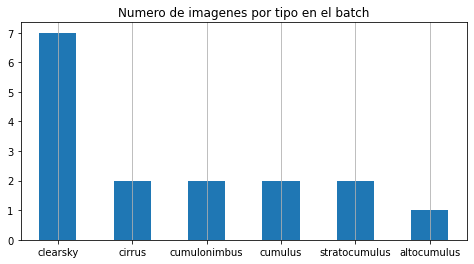

In [56]:
plt.figure(figsize=(8,4))
df['target'].value_counts().plot.bar()
plt.grid(axis='x')
plt.xticks(rotation=0)
plt.title('Numero de imagenes por tipo en el batch')
plt.show()

### DEEP FEATURES

In [57]:
cnn = nn.Sequential(*(list(models.resnet50(pretrained=True).children())[:-1]))

In [58]:
batch_images = torch.tensor(images ,dtype=torch.float)

In [59]:
with torch.no_grad():
    features = cnn(torch.tensor(images).float()).reshape(-1,2048)

In [60]:
features.shape

torch.Size([16, 2048])

### SIMILARITY AND ADJACENCY MATRIX

In [61]:
THRESHOLD=0.7

In [62]:
norm = features.norm(dim=1).view(-1,1)
batch = features/norm

#########
sim_matrix = batch @ batch.T
adj_matrix = torch.where(sim_matrix>THRESHOLD, 1, 0)

### Plot

In [63]:
G = nx.from_numpy_matrix(adj_matrix.numpy(), create_using=nx.Graph)

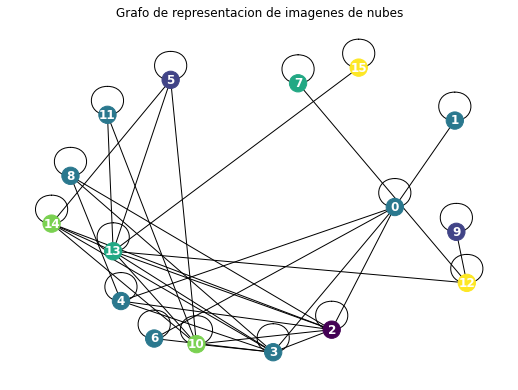

In [64]:
plt.figure(1,figsize=(7,5)) 
nx.draw(G, nx.spring_layout(G, k=10/np.sqrt(G.number_of_nodes())), with_labels=True, node_color=df['label'], font_color="white", font_weight="bold")
plt.title('Grafo de representacion de imagenes de nubes')
plt.show()

#### DGL

In [65]:
row, col = torch.where(adj_matrix==1)

In [66]:
g = dgl.graph((row, col))

In [67]:
g 

Graph(num_nodes=16, num_edges=76,
      ndata_schemes={}
      edata_schemes={})

### GCN Layer test

In [68]:
gcd_layer = dgl.nn.GraphConv(2048, 512)

mp_features = gcd_layer(g, features)
print(mp_features.shape)

torch.Size([16, 512])


---

## CAC COEFFICIENTS

#### 1. Sample z neighbours for each node, excluding itself

In [69]:
#OVERWRITE 
sim_matrix.fill_diagonal_(0)

num_neighbours = 2
indices = torch.topk(sim_matrix, num_neighbours, dim=1).indices

In [70]:
# SAMPLE NEIGHBOURHOOD 
neighbours = features[indices]

### CAC computation

In [71]:
u1 = nn.Linear(2048, 256, bias=False)
v1 = nn.Linear(2048, 256, bias=False)

u2 = nn.Linear(2048, 256, bias=False)
v2 = nn.Linear(2048, 256, bias=False)

In [72]:
feat_src = u1(features)
feat_dst = v1(features)

neigh_src = u2(neighbours).mean(1)
neigh_dst = v2(neighbours).mean(1)

In [73]:
def edge_udf(edges):
    return {'raw_coef': (edges.src['feat_src']*edges.src['feat_dst']).sum(1) + (edges.dst['neigh_src']*edges.dst['neigh_dst']).sum(1)/num_neighbours**2}

In [74]:
with g.local_scope():
    
    g.ndata['feat_src'] = feat_src
    g.ndata['feat_dst'] = feat_dst
    g.ndata['neigh_src'] = neigh_src
    g.ndata['neigh_dst'] = neigh_dst
    
    g.apply_edges(edge_udf)
    g.edata['cac'] = edge_softmax(g, g.edata['raw_coef'])
    g.update_all(fn.u_mul_e('feat_src', 'cac', 'm'), fn.mean('m', 'h'))
    
    print(g.dstdata['h'].shape)

torch.Size([16, 256])
